# Import Libraries

In [38]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [39]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ToTensor(),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])


# Dataset and Creating Train/Test Split

In [40]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [41]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

train_dataloader = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)


CUDA Available? False


In [ ]:
train.data

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: tensor(120.7076)
 - std: tensor(64.1501)
 - var: tensor(4115.2324)
torch.Size([64, 3, 32, 32])
torch.Size([64])


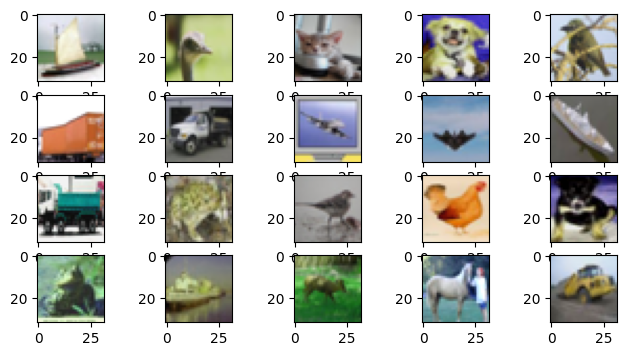

In [42]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())
train_data = train.data

torch_tensor = torch.from_numpy(train_data)

print('[Train]')
print(' - Numpy Shape:', train_data.shape)
print(' - Tensor Shape:', torch_tensor.size())
print(' - min:', torch.min(torch_tensor))
print(' - max:', torch.max(torch_tensor))
print(' - mean:', torch.mean(torch_tensor.float()))
print(' - std:', torch.std(torch_tensor.float()))
print(' - var:', torch.var(torch_tensor.float()))

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

images = images.numpy()

plt.figure(figsize=(8,4))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(np.transpose(images[i],(1,2,0))/2+0.5)

plt.show()

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [ ]:
images.shape

(64, 3, 32, 32)

# The model
Let's start with the model we first saw

In [45]:
from models import S8_LN_Model
Net = S8_LN_Model

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [46]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
input_channels = model.convblock1[0].in_channels
summary(model, input_size=(input_channels, 32, 32))
# print(model)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 34, 34]             135
         LayerNorm-2            [-1, 5, 34, 34]          11,560
              ReLU-3            [-1, 5, 34, 34]               0
           Dropout-4            [-1, 5, 34, 34]               0
            Conv2d-5            [-1, 5, 32, 32]             225
         LayerNorm-6            [-1, 5, 32, 32]          10,240
              ReLU-7            [-1, 5, 32, 32]               0
           Dropout-8            [-1, 5, 32, 32]               0
            Conv2d-9           [-1, 10, 32, 32]              50
        MaxPool2d-10           [-1, 10, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,440
        LayerNorm-12           [-1, 16, 16, 16]           8,192
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14           [-1,

In [ ]:
print(model)

Net(
  (convblock1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), bias=False)
    (1): LayerNorm((5, 34, 34), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): LayerNorm((5, 32, 32), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock3): Sequential(
    (0): Conv2d(5, 10, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convblock4): Sequential(
    (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): LayerNorm((16, 16, 16), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
 

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 0


Loss=1.7528609037399292 Batch_id=781 Accuracy=26.18: 100%|██████████| 782/782 [03:10<00:00,  4.09it/s]



Test set: Average loss: 1.7860, Accuracy: 3280/10000 (32.80%)

EPOCH: 1


Loss=1.6410945653915405 Batch_id=781 Accuracy=36.50: 100%|██████████| 782/782 [03:18<00:00,  3.94it/s]



Test set: Average loss: 1.6150, Accuracy: 3858/10000 (38.58%)

EPOCH: 2


Loss=1.4983384609222412 Batch_id=781 Accuracy=41.17: 100%|██████████| 782/782 [03:15<00:00,  4.00it/s]



Test set: Average loss: 1.5658, Accuracy: 4136/10000 (41.36%)

EPOCH: 3


Loss=1.0497918128967285 Batch_id=781 Accuracy=44.30: 100%|██████████| 782/782 [03:01<00:00,  4.30it/s]



Test set: Average loss: 1.4744, Accuracy: 4501/10000 (45.01%)

EPOCH: 4


Loss=1.8386224508285522 Batch_id=781 Accuracy=46.73: 100%|██████████| 782/782 [02:53<00:00,  4.50it/s]



Test set: Average loss: 1.3835, Accuracy: 4857/10000 (48.57%)

EPOCH: 5


Loss=1.044844150543213 Batch_id=781 Accuracy=48.60: 100%|██████████| 782/782 [02:59<00:00,  4.35it/s]



Test set: Average loss: 1.5106, Accuracy: 4554/10000 (45.54%)

EPOCH: 6


Loss=1.2510157823562622 Batch_id=781 Accuracy=49.68: 100%|██████████| 782/782 [03:02<00:00,  4.29it/s]



Test set: Average loss: 1.3842, Accuracy: 4886/10000 (48.86%)

EPOCH: 7


Loss=1.2653995752334595 Batch_id=781 Accuracy=50.66: 100%|██████████| 782/782 [03:07<00:00,  4.17it/s]



Test set: Average loss: 1.3773, Accuracy: 4929/10000 (49.29%)

EPOCH: 8


Loss=1.3136978149414062 Batch_id=781 Accuracy=51.94: 100%|██████████| 782/782 [02:56<00:00,  4.43it/s]



Test set: Average loss: 1.3847, Accuracy: 4961/10000 (49.61%)

EPOCH: 9


Loss=1.1907837390899658 Batch_id=781 Accuracy=53.01: 100%|██████████| 782/782 [02:58<00:00,  4.37it/s]



Test set: Average loss: 1.3657, Accuracy: 5135/10000 (51.35%)

EPOCH: 10


Loss=1.2417056560516357 Batch_id=781 Accuracy=53.65: 100%|██████████| 782/782 [02:45<00:00,  4.72it/s]



Test set: Average loss: 1.2710, Accuracy: 5320/10000 (53.20%)

EPOCH: 11


Loss=0.9152206182479858 Batch_id=781 Accuracy=54.39: 100%|██████████| 782/782 [02:50<00:00,  4.57it/s]



Test set: Average loss: 1.2370, Accuracy: 5529/10000 (55.29%)

EPOCH: 12


Loss=1.9156532287597656 Batch_id=781 Accuracy=55.00: 100%|██████████| 782/782 [02:57<00:00,  4.42it/s]



Test set: Average loss: 1.2656, Accuracy: 5465/10000 (54.65%)

EPOCH: 13


Loss=0.8804029226303101 Batch_id=781 Accuracy=55.40: 100%|██████████| 782/782 [03:02<00:00,  4.27it/s]



Test set: Average loss: 1.1618, Accuracy: 5781/10000 (57.81%)

EPOCH: 14


Loss=0.7110117077827454 Batch_id=781 Accuracy=56.01: 100%|██████████| 782/782 [02:53<00:00,  4.50it/s]



Test set: Average loss: 1.1412, Accuracy: 5923/10000 (59.23%)

EPOCH: 15


Loss=1.7570183277130127 Batch_id=781 Accuracy=56.63: 100%|██████████| 782/782 [02:48<00:00,  4.63it/s]



Test set: Average loss: 1.2065, Accuracy: 5665/10000 (56.65%)

EPOCH: 16


Loss=1.0537073612213135 Batch_id=781 Accuracy=56.65: 100%|██████████| 782/782 [02:57<00:00,  4.39it/s]



Test set: Average loss: 1.2015, Accuracy: 5649/10000 (56.49%)

EPOCH: 17


Loss=1.2859292030334473 Batch_id=781 Accuracy=57.44: 100%|██████████| 782/782 [03:07<00:00,  4.17it/s]



Test set: Average loss: 1.1764, Accuracy: 5759/10000 (57.59%)

EPOCH: 18


Loss=1.159833312034607 Batch_id=781 Accuracy=57.81: 100%|██████████| 782/782 [03:07<00:00,  4.17it/s]



Test set: Average loss: 1.1844, Accuracy: 5722/10000 (57.22%)

EPOCH: 19


Loss=0.8481432199478149 Batch_id=781 Accuracy=58.40: 100%|██████████| 782/782 [03:01<00:00,  4.31it/s]



Test set: Average loss: 1.0876, Accuracy: 6136/10000 (61.36%)



Text(0.5, 1.0, 'Test Accuracy')

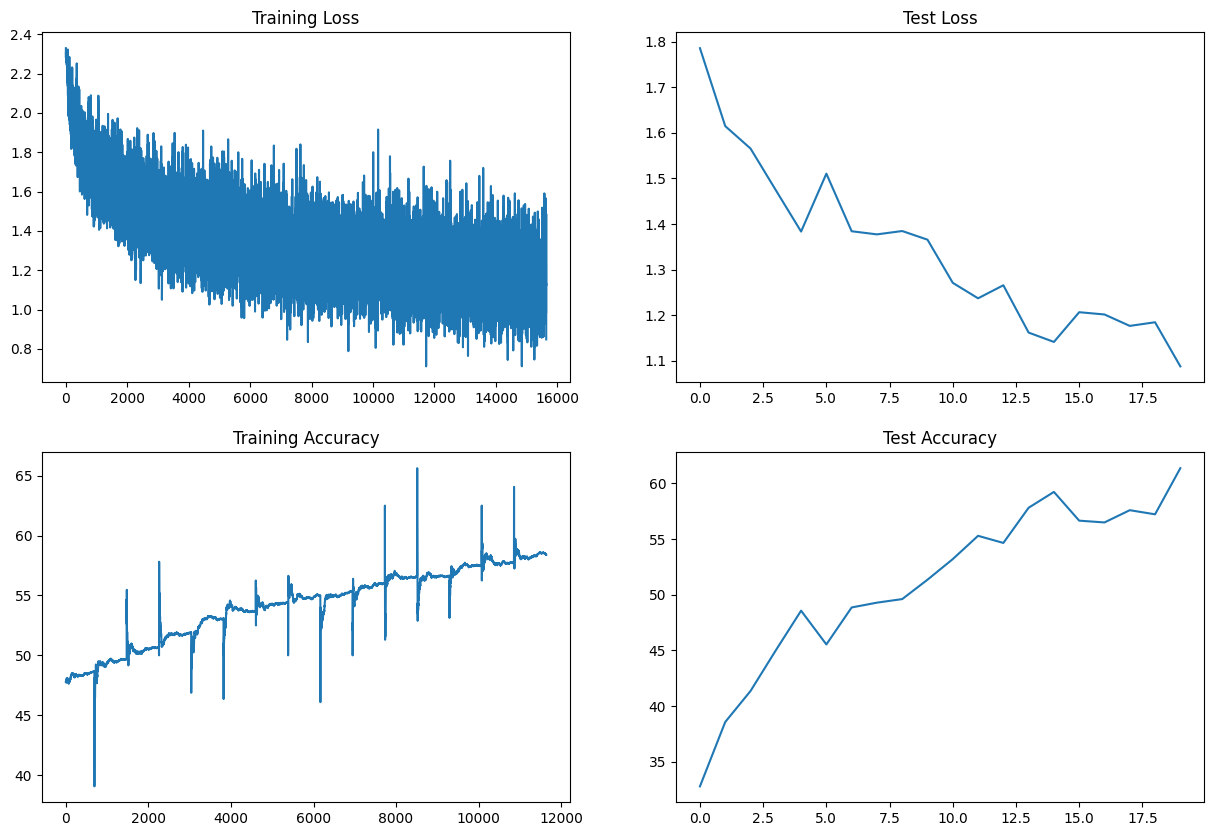

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
import numpy as np

def misclassified(model, testloader):
  classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  # Testing the model and printing misclassified images
  misclassified_images = []
  misclassified_labels = []
  predicted_label_list = []
  for index in range(500):
      k = np.random.randint(0, len(test_dataloader.dataset))  # random points from test dataset

      img, label = test_dataloader.dataset[k]  # separate the image and label
      img = img.unsqueeze(0)  # adding one dimention
      pred = model(img.to(device))  # Prediction
      predicted_label = pred.argmax().item()
      if label != predicted_label:
          misclassified_labels.append(classes[label])
          misclassified_images.append(img)
          predicted_label_list.append(classes[predicted_label])
      if len(misclassified_labels) == 10:
          break
  print(misclassified_labels)
  plt.figure(figsize=(10, 5))
  for i in range(10):
      plt.subplot(2, 5, i + 1)
      plt.imshow(misclassified_images[i].squeeze().permute(1,2,0), cmap="gray")
      plt.title(f"Predcited label {predicted_label_list[i]}\n True Label: {misclassified_labels[i]}")
      plt.axis('off')
  plt.show()



['deer', 'dog', 'bird', 'horse', 'dog', 'frog', 'deer', 'frog', 'horse', 'frog']


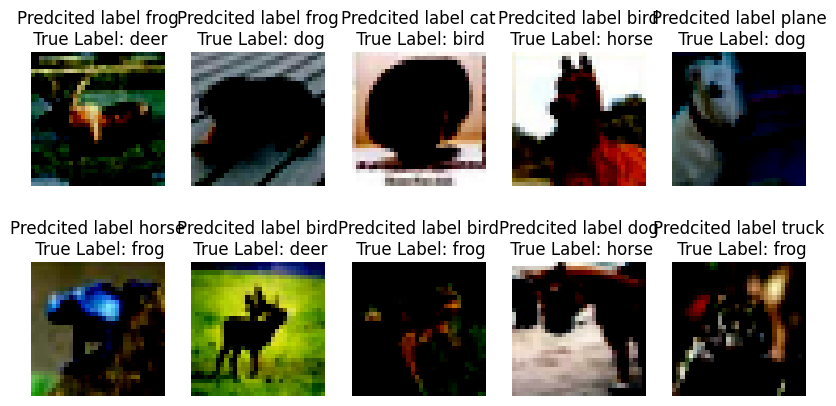

In [ ]:
misclassified(model, test_dataloader)